# LiDAR FRC Field Position Calculations

This is a notebook that displays how to use Lidar points to align a robot to an FRC Field to produce a position and heading on the field.


In [1]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, pi

sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('./'))

from icp import icp_svd, center_data, get_correspondence_indices, compute_cross_covariance
from chart import draw_correspondences, plot_data, plot_values, animate_results, show_map_image
from map import load_frc2019_field, Robot

plt.rcParams["figure.figsize"]=30,30

### LiDAR Map

This is where we set up the LiDAR Map examples to test them. First, is the FRC2019 field itself.

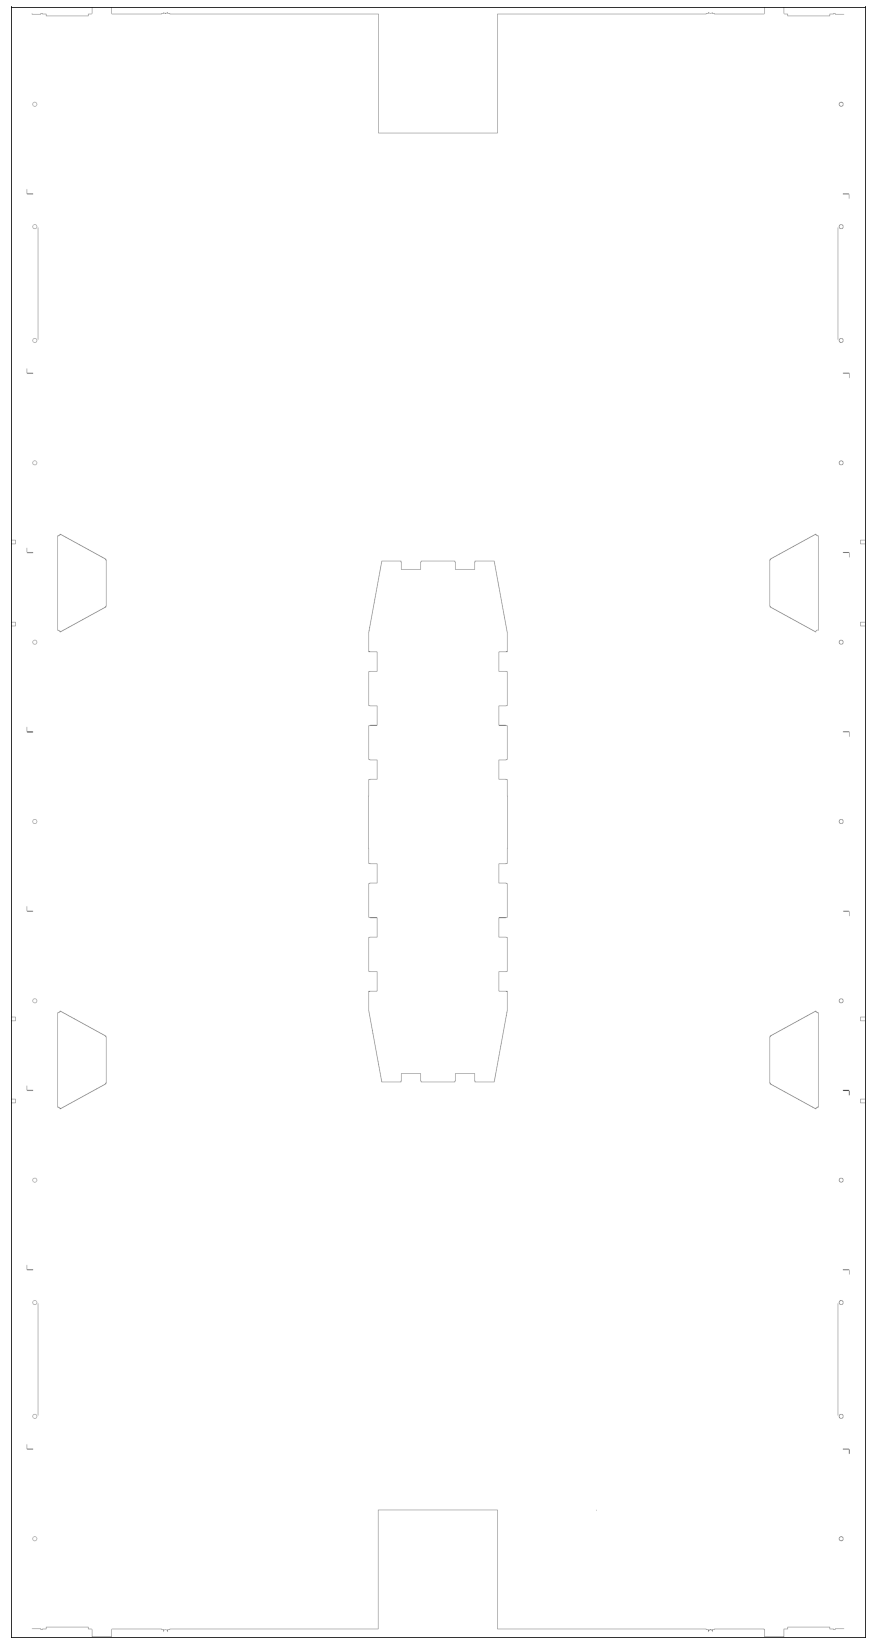

In [2]:
frc2019_field = load_frc2019_field()

show_map_image(np.asarray(frc2019_field.image))

#### Robot Position on Map

Adding a Robot object onto the map allows us to track position and visualize it

In [3]:
robot = Robot()

robot.set_position(-2000.0, -6000.0, 45.0)

show_map_image(np.asarray(frc2019_field.draw_map_with_robot(robot)))

TypeError: integer argument expected, got float

#### Display Local Map relative to Robot

This is useful for more close-up visual work

In [ ]:
show_map_image(np.asarray(frc2019_field.draw_local_map(robot, 4000)))

In [ ]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.array([[cos(angle), -sin(angle)], 
                   [sin(angle),  cos(angle)]])
t_true = np.array([[-2], [5]])

# Generate data as a list of 2d points
num_points = 30
sin_true_data = np.zeros((2, num_points))
sin_true_data[0, :] = range(0, num_points)
sin_true_data[1, :] = 0.2 * sin_true_data[0, :] * np.sin(0.5 * sin_true_data[0, :]) 
# Move the data
sin_moved_data = R_true.dot(sin_true_data) + t_true

field = np.zeros((2, num_points))
#scan = np.zeros((2, 500))



field[0, :] = range(0, num_points)

field[0, 0] = 1
field[1, 0] = 1
field[0, 1] = 1
field[1, 1] = 2
field[0, 2] = 1
field[1, 2] = 3
field[0, 3] = 1
field[1, 3] = 4
field[0, 4] = 1
field[1, 4] = 5
field[0, 5] = 1
field[1, 5] = 6
field[0, 6] = 1
field[1, 6] = 7
field[0, 7] = 1
field[1, 7] = 8
field[0, 8] = 1
field[1, 8] = 9
field[0, 9] = 1
field[1, 9] = 10
field[0, 10] = 1
field[1, 10] = 10
field[0, 11] = 2
field[1, 11] = 10
field[0, 12] = 3
field[1, 12] = 10
field[0, 13] = 4
field[1, 13] = 10
field[0, 14] = 5
field[1, 14] = 10
field[0, 15] = 6
field[1, 15] = 10
field[0, 16] = 7
field[1, 16] = 10
field[0, 17] = 8
field[1, 17] = 10
field[0, 18] = 9
field[1, 18] = 10
field[0, 19] = 10
field[1, 19] = 10
field[0, 20] = 11
field[1, 20] = 10
field[0, 21] = 12
field[1, 21] = 10
field[0, 22] = 13
field[1, 22] = 10
field[0, 23] = 14
field[1, 23] = 10
field[0, 24] = 15
field[1, 24] = 10
field[0, 25] = 16
field[1, 25] = 10
field[0, 26] = 17
field[1, 26] = 10
field[0, 27] = 18
field[1, 27] = 10
field[0, 28] = 19
field[1, 28] = 10
field[0, 29] = 20
field[1, 29] = 10


scan = R_true.dot(field) + t_true


# Assign to variables we use in formulas.
Q = field
P = scan

plot_data(P, Q, "P: scan", "Q: map")
plt.show()

### Center both in graph

In [ ]:
center_of_P, P_centered = center_data(P)
center_of_Q, Q_centered = center_data(Q)
ax = plot_data(P_centered, Q_centered,
               label_1='Moved data centered',
               label_2='True data centered')
plt.show()


### Calculate correspondences

In [ ]:
correspondences = get_correspondence_indices(P_centered, Q_centered)
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered')
draw_correspondences(P_centered, Q_centered, correspondences, ax)
plt.show()

### Compute Cross Covariance

In [ ]:
cov, _ = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

### Iterative Example

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

In [ ]:
animate_results(P_values, Q, correspondences, corresp_values, xlim=(-5, 35), ylim=(-5, 35))